In [47]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [2]:
train = pd.read_csv('mental_train.csv')
test = pd.read_csv('mental_test.csv')

- 목표: Deppession (이진 분류)
- 데이터 특징: 범주형 + 수치형 + 민감 응답 혼합

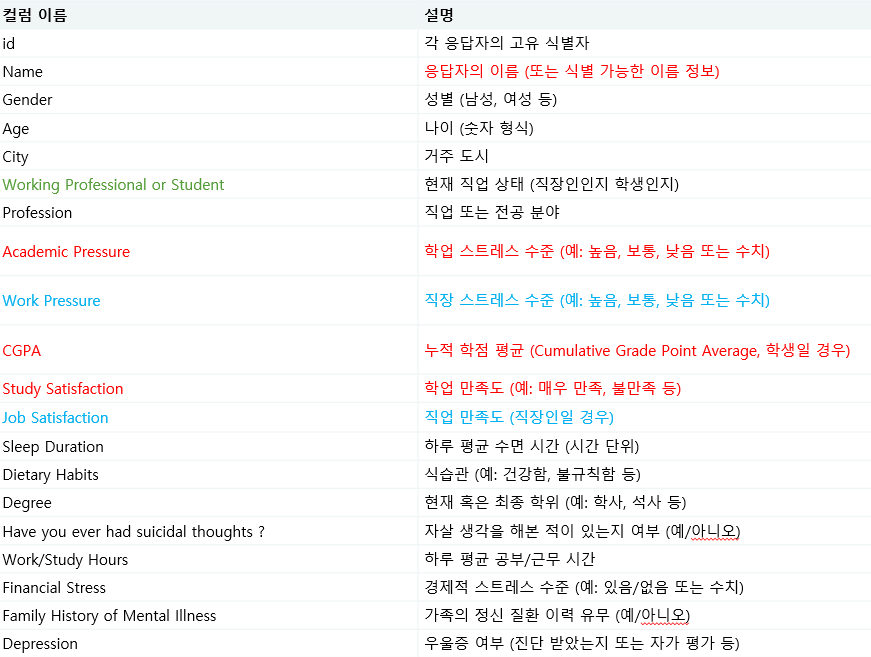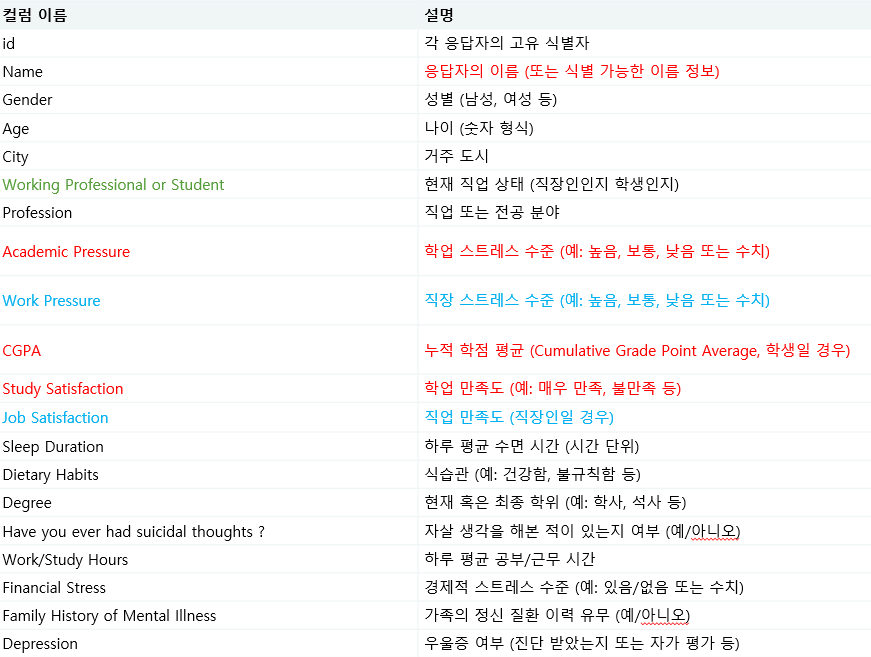

## 전처리

### 0. 삭제

In [3]:
train.drop(columns=['id'], inplace=True)
train.drop(columns=['Name'], inplace=True)

### 1. Sleep Duration

- 기준을 만들어서 float 형으로 변환

In [4]:
train['Sleep Duration'].value_counts()

Sleep Duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
3-4 hours               12
6-7 hours                8
4-5 hours                7
2-3 hours                5
4-6 hours                5
6-8 hours                4
1-6 hours                4
No                       4
9-11 hours               2
10-11 hours              2
Sleep_Duration           2
Unhealthy                2
45                       2
8-9 hours                2
10-6 hours               1
9-5                      1
45-48 hours              1
3-6 hours                1
Work_Study_Hours         1
49 hours                 1
than 5 hours             1
Pune                     1
9-6 hours                1
8 hours                  1
35-36 hours              1
Indore                   1
1-3 hours                1
55-66 hours              1
Moderate                 1
40-45 hours              1
1-2 hours                1
9-5 hours                1
Name: count, 

In [5]:
# 이상치, 알 수 없는 값들 제거
delete_values = [
    'Indore', 'Pune', 'Moderate', 'Unhealthy', 'Sleep_Duration',
    'Work_Study_Hours', 'No', '45', '49 hours', '55-66 hours', '40-45 hours', 
    '9-5 hours', '10-6 hours', '9-6 hours', '9-5', '45-48 hours', '35-36 hours'
]

train = train[~train['Sleep Duration'].isin(delete_values)].copy()

In [6]:
train['Sleep Duration'].value_counts()

Sleep Duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
3-4 hours               12
6-7 hours                8
4-5 hours                7
2-3 hours                5
4-6 hours                5
1-6 hours                4
6-8 hours                4
8-9 hours                2
9-11 hours               2
10-11 hours              2
1-3 hours                1
1-2 hours                1
8 hours                  1
than 5 hours             1
3-6 hours                1
Name: count, dtype: int64

In [7]:
import numpy as np
import re

def convert_sleep_to_hours(val):
    try:
        val = str(val).strip().lower()

        # 특별 처리: 'than n hours' → 'less than n hours' 간주
        if 'than' in val and 'less' not in val and 'more' not in val:
            match = re.search(r'\d+', val)
            if match:
                return float(match.group()) - 0.5

        # Less than n hours → n - 0.5
        if 'less than' in val:
            match = re.search(r'\d+', val)
            if match:
                return float(match.group()) - 0.5

        # More than n hours → n + 0.5
        elif 'more than' in val:
            match = re.search(r'\d+', val)
            if match:
                return float(match.group()) + 0.5

        # 정확히 n hours → 숫자만 추출
        elif re.match(r'^\d+\s*hours$', val):
            return float(re.findall(r'\d+', val)[0])

        # n-m hours 또는 n–n → 평균값
        elif re.search(r'\d+\s*[-–~]\s*\d+', val):
            nums = [int(n) for n in re.findall(r'\d+', val)]
            if len(nums) == 2:
                return sum(nums) / 2

        # 숫자만 → 그대로
        elif re.match(r'^\d+(\.\d+)?$', val):
            return float(val)

        # 나머지는 이상값으로 간주
        else:
            return np.nan

    except:
        return np.nan


In [8]:
train['Sleep Duration'] = train['Sleep Duration'].apply(convert_sleep_to_hours)


In [9]:
train['Sleep Duration'].value_counts()

Sleep Duration
4.5     38793
7.5     36969
8.5     32728
5.5     32142
3.5        16
6.5         8
5.0         5
2.5         5
7.0         4
10.5        2
10.0        2
1.5         1
2.0         1
8.0         1
Name: count, dtype: int64

In [10]:
print(train['Sleep Duration'].dtype)

float64


## 2. 결측치 처리

#### 2-1. 결측률 80%

- 파생 변수 만들어서(결측 여부) 의미 있는 누락 정보 보존 + 과적합 방지 할 것인지
- 아니면 값을 대체할지 

일단 파생 변수를 만들어 보겠음. 

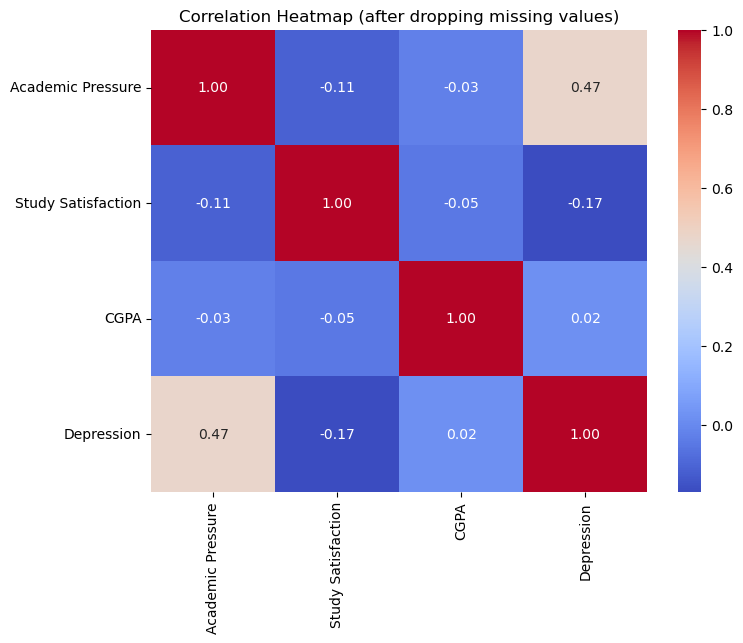

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 필요한 컬럼만 선택하고 결측치 제거
cols = ['Academic Pressure', 'Study Satisfaction', 'CGPA', 'Depression']
subset = train[cols].dropna()

# 상관관계 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(subset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (after dropping missing values)")
plt.show()

In [12]:
# 1. CGPA 컬럼 제거
train.drop(columns=['CGPA'], inplace=True)

In [13]:
# 2. Academic Pressure 결측 여부 파생 변수
train['Academic_Pressure_missing'] = train['Academic Pressure'].isnull().astype(int)

# 3. Study Satisfaction 결측 여부 파생 변수
train['Study_Satisfaction_missing'] = train['Study Satisfaction'].isnull().astype(int)

In [14]:
train['Academic_Pressure_missing']

0         1
1         1
2         0
3         1
4         1
         ..
140695    1
140696    1
140697    1
140698    1
140699    0
Name: Academic_Pressure_missing, Length: 140677, dtype: int32

*결과 예시*

| Academic Pressure | Academic\_Pressure\_missing | Study Satisfaction | Study\_Satisfaction\_missing |
| ----------------- | --------------------------- | ------------------ | ---------------------------- |
| 3.0               | 0                           | 4.0                | 0                            |
| NaN               | 1                           | NaN                | 1                            |
| 2.0               | 0                           | NaN                | 1                            |


- 원래 컬럼의 nan은 어떻게 처리?

    - 파생 변수를 만들었기 때문에, 그대로 두어도 됨.
    - 결측 여부 정보를 이미 담고 있어서
    - 하지만 사용하는 모델에 따라 nan을 허용하지 않으면 대체해야 함

1. 평균값 대체
- 가능은 하지만 무분별한 평균 대체는 정보 손실 및 왜곡을 유발할 수 있음.
- 특히 결측 자체가 의미를 갖는 경우(예: 설문 무응답 → 스트레스 회피?)엔 단순 평균은 부적절할 수 있음.
- 
```
train['Academic Pressure'].fillna(train['Academic Pressure'].median(), inplace=True)
train['Study Satisfaction'].fillna(train['Study Satisfaction'].median(), inplace=True)
```

2. imputer로 값 채우기
- 권장되는 방식!

- 파생 변수 없이 평균값 대체만 하면
    - 결측값이 있었다는 정보를 완전히 잃어버림
    - 실제로 결측이 의미를 가지는 경우 오히려 성능 저하


In [15]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # 또는 'median', 'most_frequent'
train['Academic Pressure'] = imputer.fit_transform(train[['Academic Pressure']])
train['Study Satisfaction'] = imputer.fit_transform(train[['Study Satisfaction']])

#### 2-2. 나머지 결측치 처리

In [16]:
train = train[train['Financial Stress'].notnull()].copy()

In [17]:
train['Work_Pressure_missing'] = train['Work Pressure'].isnull().astype(int)

train['Study_Satisfaction_missing'] = train['Study Satisfaction'].isnull().astype(int)

In [18]:
train['Work Pressure'] = imputer.fit_transform(train[['Work Pressure']])
train['Job Satisfaction'] = imputer.fit_transform(train[['Job Satisfaction']])

In [19]:
print(train.isnull().sum().sort_values(ascending=False).head())

Profession                    36621
Dietary Habits                    4
Degree                            2
Study_Satisfaction_missing        0
Academic_Pressure_missing         0
dtype: int64


#### 2-3. 범주형 결측치 처리

In [20]:
train['Profession'].fillna('Missing', inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_20100\4215184188.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Profession'].fillna('Missing', inplace=True)


In [21]:
print(train.isnull().sum().sort_values(ascending=False).head())

Dietary Habits                4
Degree                        2
Age                           0
Study_Satisfaction_missing    0
Academic_Pressure_missing     0
dtype: int64


### 3. 수치형 컬럼 스케일링

In [22]:
train.describe()

,Age,Academic Pressure,Work Pressure,Study Satisfaction,Job Satisfaction,Sleep Duration,Work/Study Hours,Financial Stress,Depression,Academic_Pressure_missing,Study_Satisfaction_missing,Work_Pressure_missing
count,140673.000000,140673.000000,140673.000000,140673.000000,140673.000000,140673.000000,140673.000000,140673.000000,140673.000000,140673.000000,140673.0,140673.000000
mean,40.388376,3.142211,2.999033,2.944745,2.974532,6.447627,6.252543,2.988967,0.181726,0.801739,0.0,0.198410
std,12.384379,0.614668,1.258645,0.605609,1.267902,1.588896,3.853676,1.413628,0.385620,0.398691,0.0,0.398804
min,18.000000,1.000000,1.000000,1.000000,1.000000,1.500000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000
25%,29.000000,3.142186,2.000000,2.944717,2.000000,4.500000,3.000000,2.000000,0.000000,1.000000,0.0,0.000000
50%,42.000000,3.142186,2.999033,2.944717,2.974532,5.500000,6.000000,3.000000,0.000000,1.000000,0.0,0.000000
75%,51.000000,3.142186,4.000000,2.944717,4.000000,7.500000,10.000000,4.000000,0.000000,1.000000,0.0,0.000000
max,60.000000,5.000000,5.000000,5.000000,5.000000,10.500000,12.000000,5.000000,1.000000,1.000000,0.0,1.000000


| 컬럼명                | 범위           | 평균 ± 표준편차           | 이유                               |
| ------------------ | ------------ | ----------------- | -------------------------------- |
| `Age`              | 18 \~ 60     | 평균40.4, std 12.4 | 넓은 범위. 다른 변수와 범위 차 큼             |
| `CGPA`             | 5.03 \~ 10.0 | 평균 7.66           | 모델에 따라 민감할 수 있음      |
| `Work/Study Hours` | 0 \~ 12      | 평균 6.25, std 3.85 | 0부터 시작, 12까지 존재 → 거리 기반 모델에 영향 큼 |
| `Financial Stress` | 1 \~ 5       | 평균 2.99           | 다른 스트레스 계열들과 통일된 스케일 유리          |

- 범위가 넓은 수치형 변수
    - 표준화를 적용하기

In [23]:
from sklearn.preprocessing import StandardScaler

scale_cols = ['Age', 'Sleep Duration', 'Work/Study Hours', 'Financial Stress']

scaler = StandardScaler()
train[scale_cols] = scaler.fit_transform(train[scale_cols])


In [24]:
train[scale_cols].describe()

,Age,Sleep Duration,Work/Study Hours,Financial Stress
count,1.406730e+05,1.406730e+05,1.406730e+05,1.406730e+05
mean,-2.196438e-16,-1.259725e-16,-5.424800e-17,1.409236e-16
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.807798e+00,-3.113887e+00,-1.622494e+00,-1.407000e+00
25%,-9.195791e-01,-1.225778e+00,-8.440136e-01,-6.995979e-01
50%,1.301341e-01,-5.964077e-01,-6.553328e-02,7.804544e-03
75%,8.568586e-01,6.623320e-01,9.724404e-01,7.152070e-01
max,1.583583e+00,2.550442e+00,1.491427e+00,1.422609e+00


### 4. 이진 범주형 -> 숫자 변환 (Yes/No → 1/0)

In [25]:
binary_cols = ['Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
for col in binary_cols:
    train[col] = train[col].map({'Yes': 1, 'No': 0})

### (5). 범주형 확인

- 원핫인코딩 전, 고차원을 방지하기 위해 이상치 처리했습니다.

#### (5)-1. City

문제점
- 도시명 외에 사람 이름 등 잘못된 값이 포함 (Shrey, Vaanya, Ivaan, Gaurav 등)
- 고유값 98개 → 원핫 인코딩 시 고차원 문제 발생

해결 방법
- 상위 K개 도시 유지 + 나머지 Other로 묶기

In [26]:
# 상위 15개 도시만 유지
top_cities = train['City'].value_counts().nlargest(15).index
train['City'] = train['City'].where(train['City'].isin(top_cities), other='Other')

In [27]:
train['City'].value_counts()

City
Other            60522
Kalyan            6590
Patna             5924
Vasai-Virar       5764
Kolkata           5687
Ahmedabad         5612
Meerut            5527
Ludhiana          5225
Pune              5210
Rajkot            5207
Visakhapatnam     5175
Srinagar          5073
Mumbai            4965
Indore            4872
Agra              4684
Surat             4636
Name: count, dtype: int64

#### (5)-2. Degree 

문제점
- 고유값 115개 → 너무 많음
- 실제 학위 외에 오타, 숫자, 이름 등이 섞여 있음 (29, Vivaan, Advait, Bhavesh, BCA, M.Tech, 등등)

해결 방법
- 빈도 기준 상위 N개만 남기고 나머지는 'Other' 처리

In [28]:
train['Degree'].value_counts()

Degree
Class 12    14727
B.Ed        11690
B.Arch       8741
B.Com        8112
B.Pharm      5856
            ...  
Vivaan          1
MTech           1
29              1
LLCom           1
Advait          1
Name: count, Length: 115, dtype: int64

In [29]:
degree_group_map = {
    # 의학/보건
    'MD': 'Medical',
    'MBBS': 'Medical',
    'B.Pharm': 'Pharmacy',
    'M.Pharm': 'Pharmacy',
    'MPharm': 'Pharmacy',
    'P.Pharm': 'Pharmacy',
    'S.Pharm': 'Pharmacy',
    'N.Pharm': 'Pharmacy',

    # 공학/기술
    'B.Tech': 'Engineering',
    'M.Tech': 'Engineering',
    'ME': 'Engineering',
    'MTech': 'Engineering',
    'M_Tech': 'Engineering',
    'BE': 'Engineering',
    'BCA': 'Engineering',
    'MCA': 'Engineering',
    'E.Tech': 'Engineering',
    'S.Tech': 'Engineering',
    'LLTech': 'Engineering',
    'LLCom': 'Engineering',

    # 인문/사회/비즈니스
    'BBA': 'Business',
    'MBA': 'Business',
    'M. Business Analyst': 'Business',
    'B.Com': 'Commerce',
    'M.Com': 'Commerce',
    'P.Com': 'Commerce',
    'LLB': 'Law',
    'LLM': 'Law',
    'LLBA': 'Law',
    'LL.Com': 'Law',
    'LL B.Ed': 'Education',
    'B.Ed': 'Education',
    'M.Ed': 'Education',
    'L.Ed': 'Education',
    'K.Ed': 'Education',
    'LLEd': 'Education',
    'BEd': 'Education',

    # 과학
    'BSc': 'Science',
    'MSc': 'Science',
    'B.Sc': 'Science',

    # 기타, 건축, 호텔경영 등
    'BHM': 'Hospitality',
    'MHM': 'Hospitality',
    'B.Arch': 'Architecture',
    'M.Arch': 'Architecture',
    'BArch': 'Architecture',
    'B.B.Arch': 'Architecture',

    # 학위 및 학교 졸업
    'PhD': 'PhD',
    'Class 12': 'School',
    'Class 11': 'School',
}

train['degree_group'] =train['Degree'].apply(lambda x: degree_group_map.get(x, 'Other'))

train=train.drop('Degree',axis=1)

In [30]:
train['degree_group'].value_counts()

degree_group
Engineering     26608
Education       17365
School          14728
Commerce        11207
Pharmacy        10397
Science          9906
Law              8996
Business         8849
Architecture     8749
Hospitality      7591
Other            6715
Medical          6460
PhD              3102
Name: count, dtype: int64

#### (5)-3. Dietary Habits

Moderate, Unhealthy, Healthy는 명확한 카테고리

나머지는 이상값 / 오입력 / 다른 컬럼에서 잘못 섞인 값임

In [31]:
train['Dietary Habits'].value_counts()

Dietary Habits
Moderate             49695
Unhealthy            46219
Healthy              44732
Yes                      2
No                       2
More Healthy             2
No Healthy               1
Class 12                 1
Indoor                   1
Male                     1
Vegas                    1
M.Tech                   1
Less Healthy             1
1.0                      1
Electrician              1
Hormonal                 1
Mihir                    1
Less than Healthy        1
3                        1
Gender                   1
BSc                      1
Pratham                  1
2                        1
Name: count, dtype: int64

In [32]:
# 정상 값만 남기고 나머지는 NaN으로
valid_dietary = ['Moderate', 'Unhealthy', 'Healthy']
train['Dietary Habits'] = train['Dietary Habits'].where(train['Dietary Habits'].isin(valid_dietary))

# 결측값은 최빈값으로 대체
train['Dietary Habits'] = train['Dietary Habits'].fillna(train['Dietary Habits'].mode()[0])


In [33]:
train['Dietary Habits'].value_counts()

Dietary Habits
Moderate     49722
Unhealthy    46219
Healthy      44732
Name: count, dtype: int64

In [34]:
from sklearn.preprocessing import LabelEncoder

# Gender, Working Status - Binary
train['Gender'] = train['Gender'].map({'Male': 1, 'Female': 0})
train['Working Professional or Student'] = train['Working Professional or Student'].map({'Working Professional': 1, 'Student': 0})

# Degree, Dietary Habits - One-hot encoding
train = pd.get_dummies(train, columns=['degree_group', 'Dietary Habits'], drop_first=True)

# Profession, City - Target encoding (또는 frequency encoding)
# 예: Target Mean Encoding (Depression 컬럼 사용)
for col in ['Profession', 'City']:
    target_mean = train.groupby(col)['Depression'].mean()
    train[col + '_target'] = train[col].map(target_mean)

# 이후 필요시 원본 컬럼 제거
train.drop(columns=['Profession', 'City'], inplace=True)

In [35]:
from sklearn.model_selection import train_test_split

def get_train_test_dataset(df=None):
    train_copy = train

    y_target = train_copy['Depression']
    X_features = train_copy.drop('Depression', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                        test_size=0.3, random_state=0, stratify=y_target)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(train)

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

model = XGBClassifier(
    n_estimators=100,       # 트리 개수 (적당함)
    max_depth=4,            # 과적합 방지용 적당한 깊이
    learning_rate=0.1,      # 기본 학습률
    subsample=0.8,          # 전체 샘플 중 일부만 사용 → 일반화 성능↑
    colsample_bytree=0.8,   # 피처 중 일부만 사용 → 과적합 방지
    use_label_encoder=False,
    eval_metric='logloss',  # 분류 문제의 표준 평가지표
    random_state=42,
    n_jobs=-1               # 병렬 처리
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

C:\ananconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:58:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9386


In [42]:
# param_grid = {
#     'n_estimators': [300, 400],        # 트리의 개수
#     'max_depth': [20],        # 트리의 최대 깊이
#     'min_samples_split': [1, 2, 3],        # 노드를 분할하기 위한 최소 샘플 수
#     'min_samples_leaf': [3, 4,8],          # 리프 노드가 되기 위한 최소 샘플 수
#     'max_features': ['sqrt'],  # 각 분할에서 고려할 특성의 최대 수
#     'bootstrap': [True, False]            # 부트스트랩 샘플 사용 여부 (기본값 True)
# }

# rf_model = RandomForestClassifier(random_state=42)

# grid_search = GridSearchCV(estimator=rf_model,
#                            param_grid=param_grid,
#                            cv=4, # 5-fold 교차 검증
#                            scoring='accuracy', # 분류 문제의 경우 정확도
#                            verbose=2, # 진행 상황 출력 레벨
#                            n_jobs=-1)

# # 그리드 서치 학습 시작
# print("GridSearchCV 학습 시작...")
# grid_search.fit(X_train, y_train)

GridSearchCV 학습 시작...
Fitting 4 folds for each of 36 candidates, totalling 144 fits


C:\ananconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
48 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ananconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ananconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\ananconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\ananconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in valid

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [20],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 4, 8],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [300, 400]},
             scoring='accuracy', verbose=2)

In [43]:
# # 최적의 하이퍼파라미터 출력
# print("최적의 하이퍼파라미터:", grid_search.best_params_)

# # 최적의 하이퍼파라미터로 얻은 교차 검증 평균 점수
# print("최고 교차 검증 점수 (Accuracy):", grid_search.best_score_)

# # 최적의 모델 (이미 최적의 파라미터로 학습된 상태)
# best_rf_model = grid_search.best_estimator_

최적의 하이퍼파라미터: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
최고 교차 검증 점수 (Accuracy): 0.936702170170895


In [44]:
# y_pred = best_rf_model.predict(X_test)
# test_accuracy = accuracy_score(y_test, y_pred)
# print(f"테스트 데이터 정확도: {test_accuracy:.4f}")

테스트 데이터 정확도: 0.9372


In [50]:
param_distributions = {
    'n_estimators': randint(100, 500),          # 100에서 499 사이의 정수 중 랜덤 선택
    'max_depth': [35, 40, 45],    # 리스트 중 랜덤 선택
    'min_samples_split': randint(2, 20),        # 2에서 19 사이의 정수 중 랜덤 선택
    'min_samples_leaf': randint(1, 20),         # 1에서 19 사이의 정수 중 랜덤 선택
    'max_features': ['sqrt', 'log2', None],     # 리스트 중 랜덤 선택
    'bootstrap': [True, False],                 # 리스트 중 랜덤 선택
    'criterion': ['gini', 'entropy'],           # 리스트 중 랜덤 선택
}

In [51]:
random_search = RandomizedSearchCV(estimator=rf_model,
                                   param_distributions=param_distributions,
                                   n_iter=100, # 100개의 조합을 랜덤하게 탐색
                                   cv=5,
                                   scoring='accuracy',
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# 5. 랜덤 서치 학습 시작
print("RandomizedSearchCV 학습 시작...")
random_search.fit(X_train, y_train)

# 6. 최적의 파라미터 및 성능 확인
print("최적의 하이퍼파라미터:", random_search.best_params_)
print("최고 교차 검증 점수 (Accuracy):", random_search.best_score_)

# 7. 최적 모델로 테스트 데이터 평가
best_rf_model_random = random_search.best_estimator_
y_pred_random = best_rf_model_random.predict(X_test)
test_accuracy_random = accuracy_score(y_test, y_pred_random)
print(f"테스트 데이터 정확도 (Random Search): {test_accuracy_random:.4f}")

RandomizedSearchCV 학습 시작...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
최적의 하이퍼파라미터: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 35, 'max_features': None, 'min_samples_leaf': 11, 'min_samples_split': 9, 'n_estimators': 288}
최고 교차 검증 점수 (Accuracy): 0.9368646413508246
테스트 데이터 정확도 (Random Search): 0.9373
